### An introduction to _Tanalysis_

#### A simple python package for utilising basic tensor network decompositions in a data-science context

Over the last two-decades, tensor network decompositions have played a huge role in the many-body physics and quantum information communities, where they have proven themselves as an essential tool in the process of both understanding and exploiting the correlation structure of many-body quantum states. For great introductions to such decompositions -  primarily aimed at the physics community - see [here](https://arxiv.org/abs/1603.03039), [here](https://arxiv.org/abs/1008.3477) and [here](https://arxiv.org/abs/1306.2164).

However, more recently, tensor network decompositions have started to attract the attention of the machine learning and data science communities. From the learning algorithms perspective tensor networks have recently begun to be utilized, amongst other applications, as a tool for investigating and understanding the [properties of deep neural networks](https://arxiv.org/abs/1704.01552), [compressing neural network layers](https://arxiv.org/abs/1611.03214) and designing [new learning algorithms](https://arxiv.org/abs/1605.05775). From a more data science perspective, it has been recognized how various tensor network decompositions can be utilised for [feature extraction and dimensionality reduction](https://arxiv.org/abs/1403.2048), particularly within the context of [multi-dimensional datasets](https://arxiv.org/abs/1503.00516), represented by [higher order tensors](https://arxiv.org/abs/1503.00516v2), such as video and colour images.

Tanalysis is a package aimed at facilitating the use of various Matrix Product State decompositions for feature extraction and dimensionality reduction. In particular the goal is to allow flexibility and ease of use, with the hope of both spurring research in this domain, while simultaneously allowing quick and easy comparisons with existing methods on real world datasets and problems.

<img src='tanalysis.jpeg'>

#### Example usage:

In what follows we illustrate the functionality provided for in the current version of tanalysis, by looking at the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset.


We begin by importing the packages we are going to use for this demonstration. In particular, in addition to tanalysis and its dependency tncontract, we will use both tensorflow and Keras, in order to illustrate a full typical use-case scenario. We also import the MNIST dataset, which is provided via tensorflow.

In [1]:
import tensorflow as tf
import numpy as np
from numpy import random as rd
import tncontract as tn
import tanalysis as ta
import time

from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential, load_model
from keras.regularizers import l1_l2
from keras.layers import Dense, Dropout

%matplotlib inline
import matplotlib.pyplot as plt

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Using TensorFlow backend.


Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


We now organize the larger MNIST dataset into three seperate datasets:

   1. training_data - a 55000x784 matrix
   2. test_data - a 10000x784 matrix
   3. total_data - a 65000x784 matrix
   
Each of these seperate datasets consists of multiple images, each one defined by 784 features, which are the greyscale values of the individual pixels.

In [2]:
training_data = mnist.train.images
training_labels = mnist.train.labels

test_data = mnist.test.images
test_labels = mnist.test.labels

training_set_size = np.shape(training_data)[0]
test_set_size = np.shape(test_data)[0]
total_set_size = training_set_size + test_set_size

total_data = np.zeros((total_set_size, np.shape(training_data)[1]))
total_data[:training_set_size, :] = training_data
total_data[training_set_size:, :] = test_data

Now we can get going with our feature extraction and dimensionality reduction. 

The first step in any of the tensor network decomposition procedures is to _tensorize_ the data by proving a valid factorization of the features dimension of the dataset - i.e. we want to transform our data matrix into a higher order tensor - see [this](https://arxiv.org/abs/1603.03039) introduction to tensor networks if this step, or the following diagrammatic notation, is unclear in any way.

<img src='decomp2.jpeg'>

Note that in many natural scenarios, such as colour images, video, or financial data, the dataset will be naturally provided as a higher-order (higher than two) tensor, and as such this first step may be unnecessary (it is however, and open question whether or not an alternative tensorization of a dataset may be helpful in extracting meaningful features, or achieving better compression).

In order to tensorize data in tanalysis (which runs on top of [tncontract](https://github.com/andrewdarmawan/tncontract)) one can either provide a custom factorization or generate one using built in methods. By convention a tensorization in tanalysis should be specified by three objects:

   1. A list detailing the factorization. The first element of this list must always be the number of examples (typically rows) in the dataset - i.e in the top tensorization shown in the above image this list would be [55000, 7,2,4,2,7].
   2. A list detailing the labels of the tensor indices. The first element of this list should always be the string "batchsize" and the subsequent elements of the list should be strings enumerating the number of tensor indices, starting at 1 - i.e. ["batchsize","1","2","3","4","5"].
   3. An integer specifying where the batch size index should be placed in the tensorization - i.e. specifiying 3 for the batch size position would result in the tensorization shown in the image below.
   
<img src='bsp.jpeg'>
   
Finally, once the tensorization has been fully specified, as above, we can use tncontract to convert the initial data tensor into a tncontract tensor object with the specified tensorization.

In [3]:
num_features = np.shape(training_data)[1]

# We can use built in functionality to generate a symmetrized maximum length factorization i.e. [550000,2,2,7,7,2,2]
pre_partition = ta.symmetrize(ta.raw_partition(num_features))   
partition = [training_set_size]
partition.extend(pre_partition)

# We generate the labels according to the convention
tensor_labels = ["batchsize"] 
labels = [str(j + 1) for j in range(np.size(pre_partition))]     
tensor_labels.extend(labels)

# We specify that the batch size index should be placed in the centre
num_cores = np.size(partition)
batch_size_position = int(round((num_cores - 1) / 2))        

# Finally we tensorize the data via tncontract, and move the batch size index into the specified position
training_data_tensor = tn.matrix_to_tensor(training_data, partition, labels=tensor_labels)
training_data_tensor.move_index("batchsize", batch_size_position)


# Alternatively we could specify a custom factorization
custom_partition = [55000,28,28]
custom_labels = ["batchsize","1","2"] 
custom_batch_size_position = 1

# and create a tensor with this speficified tensorization
training_data_tensor_2 = tn.matrix_to_tensor(training_data, custom_partition, labels=custom_labels)
training_data_tensor_2.move_index("batchsize", custom_batch_size_position)

As you can now see, we have successfully generated the tncontract tensor objects according to our specifications (Don't worry about the zeros, these are just the white pixels on the border of the images).

In [4]:
print(training_data_tensor)

Tensor object: 
Data type: float32
Number of indices: 7

Index labels:
   0. (dim=2) 1
   1. (dim=2) 2
   2. (dim=7) 3
   3. (dim=55000) batchsize
   4. (dim=7) 4
   5. (dim=2) 5
   6. (dim=2) 6

Tensor data = 
[[[[[[[ 0.          0.        ]
      [ 0.          0.        ]]

     [[ 0.          0.        ]
      [ 0.          0.        ]]

     [[ 0.          0.        ]
      [ 0.          0.        ]]

     ..., 
     [[ 0.          0.        ]
      [ 0.          0.        ]]

     [[ 0.          0.        ]
      [ 0.          0.        ]]

     [[ 0.          0.        ]
      [ 0.          0.        ]]]


...
Printed output of large array was truncated.
String representation of full data array returned by tensor.data.__str__().


In [5]:
print(training_data_tensor_2)

Tensor object: 
Data type: float32
Number of indices: 3

Index labels:
   0. (dim=28) 1
   1. (dim=55000) batchsize
   2. (dim=28) 2

Tensor data = 
[[[ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  ..., 
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]]

 [[ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  ..., 
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]]

 [[ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  ..., 
...
Printed output of large array was truncated.
String representation of full data array returned by tensor.data.__str__().


At this stage its possible to go ahead and perform any of the decompositions catered for by tanalysis - for an introduction to the different canonical forms of matrix product states (MPS) currently implemented in tanalysis (in particular the mixed canonical form) see [here](https://arxiv.org/abs/1008.3477).

The first option is a full mixed canonical decomposition, with a variety of options. Firstly, we can choose whether to truncate _all_ bonds, or just truncate the bonds attached to the core tensor. We can also choose whether to return just the core tensor, or the core tensor along with the left canonical part and the right canonical part of the MPS, as illustrated below.

<img src='mc.jpeg'>

Furthermore, we can specify whether or not we would like the method to return the pre and post truncation singular values across bonds, which may help with diagnosis of the method and optimizing the bond-dimension. As a note, for those with previous experience with tensor networks, the decompositions in tanalysis provide _unnormalized_ vectors (just to keep in mind). 

In [6]:
# First we set the desired bond dimension of the truncations
bond_dimension = 3

# mixed canonical decomposition, truncation of all bonds, returning the whole MPS and singular values
left_1,right_1,core_1, full_sv_1, ret_sv_1 = ta.mixed_canonical_full_ret_sv(training_data_tensor,
                                                                             bond_dimension,
                                                                             batch_size_position)

# mixed canonical decomposition, truncation of all bonds, returning only core tensor and singular values
core_2,full_sv_2, ret_sv_2 = ta.mixed_canonical_core_only_ret_sv(training_data_tensor,
                                                                 bond_dimension,
                                                                 batch_size_position)

# mixed canonical decomposition, truncation of all bonds, returning only the core tensor
core_3 = ta.mixed_canonical_core_only(training_data_tensor,bond_dimension,batch_size_position)

# mixed canonical decomposition, core truncation only, returning the whole MPS and singular values
left_4, right_4, core_4,full_sv_4,ret_sv_4 = ta.mixed_canonical_full_core_truncation_only_ret_sv(training_data_tensor,
                                                                                   bond_dimension,
                                                                                   batch_size_position)

# mixed canonical decomposition, core truncation only, returning the whole MPS and no singular values
left_5, right_5, core_5 = ta.mixed_canonical_full_core_truncation_only(training_data_tensor,
                                                       bond_dimension,
                                                       batch_size_position)

# mixed canonical decomposition, core truncation only, returning only the core and the singular values
core_6, full_sv_6, ret_sv_6 = ta.mixed_canonical_core_only_core_truncation_only_ret_sv(training_data_tensor,
                                                       bond_dimension,
                                                       batch_size_position)

# All permutations are possible!

By looking at the number of singular values across each bond before and after truncation we can verify that the method has worked correctly. Furthermore, by looking at the singular values themselves we could make decisions regarding the suitability of this bond dimension.

In [7]:
full_bs_list_1 = [np.size(full_sv_1[k]) for k in range(np.shape(full_sv_1)[0])]
ret_bs_list_1 = [np.size(ret_sv_1[k]) for k in range(np.shape(ret_sv_1)[0])]

print(full_bs_list_1)
print(ret_bs_list_1)

[2, 4, 21, 21, 4, 2]
[2, 3, 3, 3, 3, 2]


Now, what we are really interested in is obtaining new compressed feature vectors. As suggested [here](https://arxiv.org/abs/1503.00516v2), and illustrated below, one method of doing this is to extract and reshape the core tensor:

<img src='reshape.jpeg'>


In [24]:
# Here we convert the core tensor into a matrix - note that the "c" tells us that we want to use the batch size index
# as the row index of the resulting matrix. By convention we always label the left index of a 3 tensor with "a", 
# the right index with "b" and the top index with "c".

reduced_training_data_1 = tn.tensor_to_matrix(core_1, "c")
print("The compressed training dataset has dimensions", np.shape(reduced_training_data_1))

The compressed training dataset has dimensions (55000, 9)


As a note, another way to extract new compressed feature _tensors_ (as opposed to _vectors_) from the mixed canonical decomposition would be to "close" the batch size index with the address of the image you are interested in, and use the entire resulting tensor - in the example above, we would have a 5-tensor after closing the batch size index - as the new feature tensor. This however would require using a learning algorithm architecture which can deal with higher order tensors as inputs (such as a [tensorized neural network](https://arxiv.org/abs/1509.06569)).

As we have seen, the above methods for "core-extraction" feature selection required explicitly tensorizing the data, if you don't want to get your hands dirty, you can also plug and play, by using the following methods which take in a matrix and return a matrix with a compressed features dimension, via the core extraction and reshaping method. Once again you have a few options, you can choose to use core truncation only, or full truncation, and you can choose whether to use the default factorization - the symmetrized max length factorization - or to supply your own factorization of the original number of features.

In [25]:
# Either you can specify that the internal methodology truncates all bonds and uses the default tensorization
core_compressed_1a = ta.core_compression(training_data, bond_dimension)

# Or, you can truncate all bonds, and supply your own tensorization (factorization) of the features dimension
factorization = [2,2,7,7,2,2]
core_compressed_1b = ta.core_compression_with_partition(training_data, 
                                                        bond_dimension,
                                                        factorization,
                                                        batch_size_position)

# Or the internal methodology can truncate only the bonds attached to the core tensor, with default tensorization
core_compressed_2a = ta.core_compression_core_truncation_only(training_data,bond_dimension)

# Or, core truncation only with the factorization supplied.
core_compressed_2b = ta.core_compression_core_truncation_only_with_partition(training_data,
                                                                             bond_dimension,
                                                                             factorization,
                                                                             batch_size_position)

# Lets verify that we get the output datasets that we expect
print("Our compressed datasets have the following dimensions:")
print()
print("1a: ",np.shape(core_compressed_1a))
print("1b: ",np.shape(core_compressed_1b))
print("2a: ",np.shape(core_compressed_2a))
print("2b: ",np.shape(core_compressed_2b))

Our compressed datasets have the following dimensions:

1a:  (55000, 25)
1b:  (55000, 25)
2a:  (55000, 25)
2b:  (55000, 25)


In addition to the mixed canonical decompositions above, we can also perform a left canonical decomposition (which is probably what you would use if you wanted to use a tensorized neural network):

In [10]:
left_canonical_mps = ta.left_canonical_decompose_no_diagnostics(training_data_tensor, bond_dimension)

Or finally, you could, obtain a left canonical decomposition not of a tensorized version of the entire dataset (as we have done above), but rather of _each feature vector individually_. Once again, this could be useful if you wanted to explore tensorized neural networks.

<img src='ind.jpeg'>


In [11]:
individual_mps_compressed_data = ta.full_dataset_individual_left_canonical_mps_compression(training_data,
                                                                                           pre_partition,
                                                                                           bond_dimension)

Now that we have extracted a new set of training features, we would like to obtain the equivalent representation of our test data. Two possible ways to do this are as follows:

   1. One could perform a decomposition of the test data set, as we did for the training data set, and then extract the core tensor, or use the whole MPS as a feature tensor in an analagous way.
   2. One could use the left and right tensors from the training set to extract a core tensor from the test set, as sugggested and discussed [here](https://arxiv.org/abs/1503.00516v2). 

The second method can be achieved easily in tanalysis as follows:

In [26]:
compressed_test_1 = ta.extract_core_tensor_via_common_features_from_matrix(test_data, left_1, right_1)
print("Our test data set now has dimensions", np.shape(compressed_test_1))

Our test data set now has dimensions (10000, 9)


Great, at this stage we have seen various methods for performing feature extraction and dimensionality reduction of both training data, and test data - which of course may be initially known, or obtained in an online fashion. These methods result in either new feature vectors, with a reduced number of parameters, or new feature tensors, also with a reduced number of parameters (and, an explictly available correlation structure). However, in certain contexts, such as this example with the MNIST data, we may want to reconstruct from our compressed/transformed feature tensors a new dataset with the same shape/size as the original dataset, to allow for visual inspection of features or calculation of certain distance metrics with respect to the original dataset.

To illustrate how tanalysis caters for this functionality (by in part utilizing tncontract methods) lets go ahead and reconstruct images from the different compressed MPS representations we have so far achieved:

  1. The fully truncated mixed canonical decomposition of the entire dataset.
  2. The "core-truncated only" mixed canonical decomposition of the entire dataset.
  3. The left canonical decomposition of the entire dataset.
  4. The left canonical decompositions of each _individual_ image.

In [13]:
# Reconstruction of a 55000x784 dataset from our fully truncated mixed canonical decomposition
training_data_reconstructed_1 = ta.reconstruct_to_matrix_from_mc(left_1, right_1, core_1)

# Reconstruction of a 55000x784 dataset from our "core-truncation only" mixed canonical decomposition
training_data_reconstructed_4 = ta.reconstruct_to_matrix_from_mc(left_4, right_4, core_4)

# Reconstruct a 550008784 dataset from our left-canonical decomposition of the entire dataset
left_canonical_reconstructed = ta.reconstruct_to_matrix(left_canonical_mps,batch_size_position)  

# Perform a left canonical decomposition of ALL feature vectors, and return a 55000x784 dataset
individual_compressed_reconstructed = \
                ta.full_dataset_individual_left_canonical_mps_compression_with_reconstruction(training_data,
                                                                                             pre_partition,
                                                                                             bond_dimension)

# Now we reshape all the 784 dimensional feature vectors into 28x28 images that we can visualize
training_images_original = tn.matrix_to_tensor(training_data,[training_set_size,28,28], labels = ["batchsize","l","r"])
training_images_compressed_1 = tn.matrix_to_tensor(training_data_reconstructed_1,[training_set_size,28,28], labels = ["batchsize","l","r"])
training_images_compressed_4 = tn.matrix_to_tensor(training_data_reconstructed_4,[training_set_size,28,28], labels = ["batchsize","l","r"])
training_images_compressed_lc = tn.matrix_to_tensor(left_canonical_reconstructed,[training_set_size,28,28], labels = ["batchsize","l","r"])
training_images_individual_compressed = np.reshape(individual_compressed_reconstructed,[training_set_size,28,28])

Now that we have these reconstructions, lets go ahead and compare them to the original images. The columns of the plots, from left to right, display a selection of:

  1. The original images
  2. The images reconstructed from the fully truncated mixed canonical decomposition.
  3. The images reconstructed from the "core-truncated only" mixed canonical decomposition.
  4. The images reconstructed from the left canonical decomposition of the entire dataset.
  5. The images reconstrued from the left canonical decompositions of each _individual_ image.

These images may not look that impressive, but a bond dimension of 3 is _extremely_ small - via the core extraction method of extracting new feature vectors, a bond dimension of 3 would result in 9 dimensional feature vectors, reduced from 784 dimensions! Hopefully this package will make it easy for you to experiment with different bond dimensions and tensorizations :)

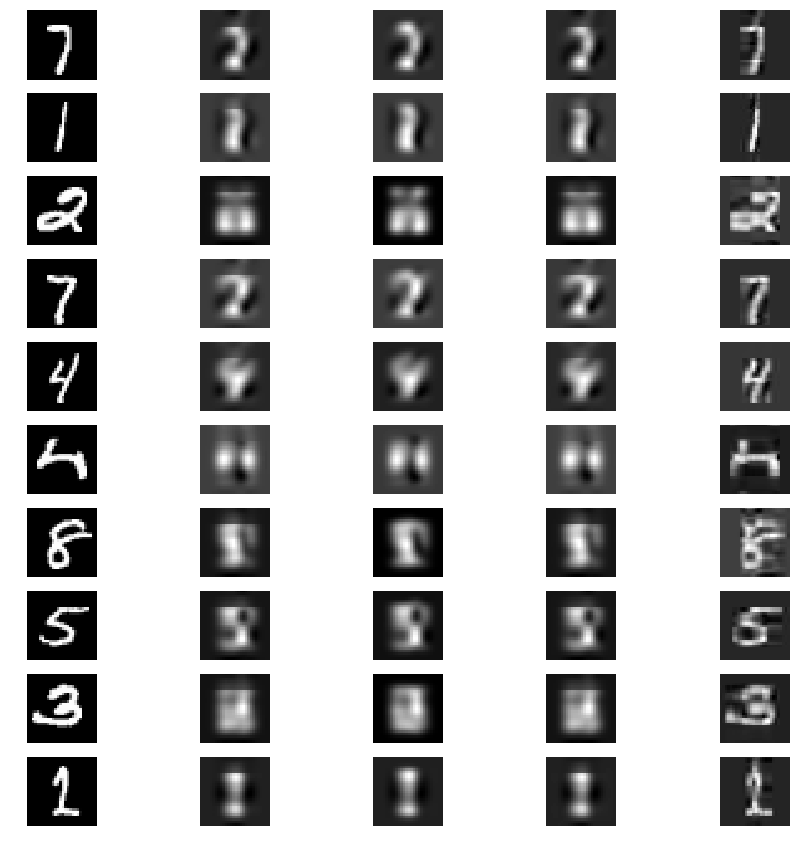

In [14]:
num_display = 10
display_indices = rd.choice(training_set_size,10,replace=False)

fig, axes1 = plt.subplots(num_display,5,figsize=(15,15))
for j in range(num_display):
        axes1[j][0].set_axis_off()
        axes1[j][0].imshow(training_images_original.data[display_indices[j],:,:], cmap = 'gray')
        axes1[j][1].set_axis_off()
        axes1[j][1].imshow(training_images_compressed_1.data[display_indices[j],:,:], cmap = 'gray')
        axes1[j][2].set_axis_off()
        axes1[j][2].imshow(training_images_compressed_4.data[display_indices[j],:,:], cmap = 'gray')
        axes1[j][3].set_axis_off()
        axes1[j][3].imshow(training_images_compressed_lc.data[display_indices[j],:,:], cmap = 'gray')
        axes1[j][4].set_axis_off()
        axes1[j][4].imshow(training_images_individual_compressed[display_indices[j],:,:], cmap = 'gray')

Great. At this stage we have achieved a pretty good overview of what tanalysis can (currently) do, and the conventions for specifying tensorizations and decompositions. To finish off lets look at a complete end-to-end example of using tanalysis as a data pre-processing recipe before a feed-forward deep neural network classifier (built using a [Keras sequential model](https://keras.io/models/sequential/)).

We will use the core-extraction method, from a fully truncated mixed canonical decomposition, as first introduced [here](https://arxiv.org/abs/1503.00516v2). 

In [19]:
# ---------------- tensorization ----------------------------------------------------------------------

# We use the default tensorization - which is the symmetrized maximum length factorization
pre_partition = ta.symmetrize(ta.raw_partition(num_features)) 
partition = [training_set_size]
partition.extend(pre_partition)

# We place the batch size index in the centre
num_cores = np.size(partition)
batch_size_position = int(round((num_cores - 1) / 2))        

# Create the labels according to the specified convention
tensor_labels = ["batchsize"]
labels = [str(j + 1) for j in range(np.size(pre_partition))]
tensor_labels.extend(labels)

# tensorize the data via tncontract
training_data_tensor = tn.matrix_to_tensor(training_data, partition, labels=tensor_labels)
training_data_tensor.move_index("batchsize", batch_size_position)

# -------------- MPS decomposition and extraction of test and training feature vectors ---------------

# Specify the bond dimension
bond_dimension = 5           

# Specify the decomposition. Return left and right tensors for extracting test features from training decomposition.
l_1,r_1,c_1 = ta.mixed_canonical_full(training_data_tensor,bond_dimension,batch_size_position)

# Extract the core tensor of the decomposition for training
compressed_training = tn.tensor_to_matrix(c_1, "c")

# Extract features from the test set via left and right tensors from the training decomposition
compressed_test = ta.extract_core_tensor_via_common_features_from_matrix(test_data, l_1, r_1)

# ------------- Build and train the FF-NN -------------------------------------------------------------

# Provide the dimensions for the input layers and output layers
num_red_features = np.shape(compressed_training)[1]
num_categories = 10

# We expect a bond dimension of 5 to result in 25 dimensional feature vectors - lets verify:
print("Each image is now represented by a "+str(num_red_features)+" dimensional vector.")

# Specify the NN architecture
ff_hidden_layers = [500,500]
ff_dropouts = [0.1,0.1]

# Specify the training details
stopping_patience = 5
batch_size = 100
epochs = 500

# Build the sequential model
nnet = Sequential()
nnet.add(Dense(ff_hidden_layers[0], activation='relu', input_shape=(num_red_features,)))
nnet.add(Dropout(ff_dropouts[0]))

count = 1
for j in ff_hidden_layers[1:]:
    nnet.add(Dense(j, activation='relu'))
    nnet.add(Dropout(ff_dropouts[count]))
    count += 1
    
nnet.add(Dense(num_categories, activation='softmax'))
nnet.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

# Train the NN model
early_stopping = EarlyStopping(monitor='val_acc', mode='auto',patience=stopping_patience)

history = nnet.fit(compressed_training, training_labels,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=0,
                    validation_split=0.1,
                    callbacks = [early_stopping])

# Evaluate the model on the test set
final_score = nnet.evaluate(compressed_test, test_labels, verbose=0)
max_acc = np.max(history.history['val_acc'])

print('Max training accuracy on validation set:', max_acc)
print('Final accuracy on test set:', final_score[1])

Each image is now represented by a 25 dimensional vector.
Max training accuracy on validation set: 0.982909097455
Final accuracy on test set: 0.9817


Great, we achieved an accuracy of just over 98%, with very few features, and a relatively simple NN. The result is definitely not state of the art, but hopefully this motivates and faciliates new experimentation and research!